# DT2470 Music Informatics Project: Automatic Mixer
Alice Anselmi | Simone Clemente | Stefano Scolari
### 1. Introduction
The goal of this project is to create an automatic mixer based on key and beat detection. The core idea is to start from a series of tracks and mix them in the best possible way considering both BPM and key similarity, providing a single mixed file as output which can be directly played on any music player. We start by analyzing the techniques applied by DJs and then we tried to replicate them in an automatic manner. The project is divided in three main areas: feature extraction, lineup composition and mixing.
### 2. Features extraction
The first step which must be applied in order to evaluate tht tracks we are working with is the features extraction: we use several methods to extract both key and beat (from which we can derive BPM too).

##### 2.1 Key Extraction

- **Deterministic Key Extraction:** This method relies on custom function to implement the Krumhansl-Schmuckler key estimation algorithm. It works by analyzing the chroma features extracted from the audio using *librosa* library and comparing them to typical profiles of major and minor keys, determining the most likely musical key.

- **Neural Network-based Key Extraction:** In this approach, the system employs *madmom* key extraction model, which utilizes a Convolutional Neural Network (CNN) to recognize the global key of a musical piece. The neural network is trained on a dataset of audio recordings and their associated key labels, allowing it to make key predictions based on the audio's features.

- **Transfer Learning Key Extraction:** This method takes advantage of the *musicnn* architecture used as backbone for the feature extraction. The *musicnn* is generally used for genre classification and it is composed by frequency and temporal filters followed by several convolutional layers. In our implementation, we use intermediate features to train a linear classifier on our dataset.

##### 2.2 BPM and Beat Extraction

- **Dynamic Beat Extraction:** The dynamic beat extraction process involves utilizing *librosa*'s beat tracking algorithm. This algorithm estimates BPMs from the onset strength envelope of the audio signal. By identifying prominent onsets and their timing, this method calculates the tempo and beat positions in the music.

- **Neural Network-based Beat Extraction:** For neural network-based beat extraction, the system employs *madmom*'s beat extraction model, which is constructed with multiple Recurrent Neural Network (RNN) layers. The RNN layers analyze the temporal patterns in the audio signal to identify beats, providing a neural network-based approach to beat extraction.
### 3. Musical lineup creation
Once we have computed the estimated key and bpm for each track it is time to order them in order to create an actual lineup. <br>The basic idea behind this process is to find tracks which are similar to each others and put them one close in order to have a seamless passage.
In order to define the similarity we could consider a 2D-dimensional plane with key and bpm as axis: our target is to find the closest neighbors of our current track. Since summing together the distances in terms of key and bpm is not simple, we decided to use an approach derived from the classical mixing theory.
##### 3.1 Key similarity
In order to find the similarity between keys we decided to apply the Camelot Wheel: this wheel is composed by two circles, the outer representing major keys and the inner for minor keys. It is often used for mixing since it indicates the keys which works well together: as a matter of fact, each key sounds well with the two neighbors in its circle and with the correspondent element from the other circle. In this way, once we select a track, we can compute the distance to reach the next track in terms of circular distance along the wheel.
<p align="center">
    <img src="imgs/CamelotWheel.jpg" alt="Image" width="600"/>
</p>

##### 3.2 BPM similarity
Once we found a metric to identify when two tracks can sound good when put together, we have to analyze their similarity in tempo. As a matter of fact, when there is a passage from one track to the other their beats must be as synchronized as possible. To do so, DJs modify the BPM in order to have a match: however, in order not to modify too much the original piece, it is advisable to modify the tempo as least as possible.
##### 3.3 Nearest neighbour technique
Once we got our two metrics we can imagine to work in a 2D plane and our task is to find the closest element at each iteration. In order to combine the two components we used a weight (which can be modified) to rule the importance we give at each metric. The distance will be computed as:
$$w1 \cdot \text{bpm\_dist} + w2 \cdot \text{key\_dist}$$
In our case w1=1 and w2=0.3.
### 4. Mix creation

##### 4.1 Beat matching
The most important thing when mixing two tracks is the beat matching aspect of it. 'Beat matching' or 'pitch cue', is a disc jockey technique of pitch shifting or time stretching an upcoming track to match its tempo to that of the currently playing track, and to adjust them such that the beats are synchronized. As previously mentioned, we thought of the output playlist in terms of a 'crescendo', meaning that we opted to favour for a track lineup where the tempo follows an increasing BPM (Beats Per Minute) order.

##### 4.2 Filtering
Another basic technique, which is commonly used for Techno and House tracks is to 'filter' out the low frequencies of the entering track. Low frequencies can be sub-bass', kick-drums and bass elements, which are not considered to introduce new musical elements and would result in a 'clashing effect' if introduced at full force on top of the low-frequency elements of the already playing track. While introducing other high and mid frequency elements together with the ones already being played is a classic approach. Once track is introduced with its high and mid frequencies, it is common to then 'swap the bass', this can be done gradually over a phrase or by arbitrary swapping them at appropriate moments during the track: these could be for example when a new phrase is introduced or whenever the DJ 'feels' it is most appropriate. It is not a science.

##### 4.3 Mixing techniques
With the previous said, the following are the **main steps** we took is our approach to achieve a similar result to what a simple mix between two tracks would look (or sound) like:
- Define a transition period, indicating how long the active overlaying of the two tracks will last.
- Gradually increase the tempo of the track which needs to be mixed out to match the tempo of the next track in the playlist. No library offered built-in functions to handle a gradual tempo increase. So we had to adopt a **mix** of pydub and ffmpeg to achieve the desired result. The trick was to subdivide the track in a high amount of subsegments, and apply a tempo increase by a calculated factor to each subsegment in order to reach the desired tempo by the desired frame of the track. This approach may lead sometimes to the introduction of a certain degree of noise.
- The track that needs to be mixed out will reach the desired tempo before the start of the transition section between the two tracks.
- Identify the first beat within the transition section of the exiting track. Meaning that we identify the frame of song where such first beat takes place.
- Identify the first beat within the transition section of the entering track.
- Overlay the exiting track from its first beat onto the exiting track on the previously identified first beat of the transition section.

<p align="center">
    <img src="imgs/Beatsync.png" alt="Image" width="900"/>
</p>

- Apply a time-varying high pass filter to the entering track. In this case the threshold representing the cutoff for the minimum frequencies is increased over time to gradually introduced the low-frequency elements. This posed an interesting challenge, as no library implemented filtering functions which changed the intensity over time, so we had to take the high-pass filter from the Pydub library and modify it for our needs.
- Apply a time-varying high pass filter to the exiting track. In this case the threshold representing the cutoff for the minimum frequencies is lowered over time to gradually remove the low-frequency elements.
- Apply a gradual volume fade-out effect to the exiting track.
- Apply a gradual volume fade-in effect to the entering track.

Repeat the process to subsequent tracks. In our case, we created a non-mixed section subject only to a gradual tempo change (if required) and a mixed-section for each pair of tracks.
This way the full mix resulted by **"simply"** appending non-mixed sections with mixed sections.

Imagine having 3 tracks in the playlist which need to be mixed, the full mix of these tracks can be broken down in the following way:
<p align="center">
    <img src="imgs/Mixed.jpg" alt="Image" width="600"/>
</p>

### 5. Dataset and methods
We will work with annotated datasets in order to have ground truth for beat and key. (For instance: https://zenodo.org/record/3967852)
Our projects aims to estimate both keys and bpm from a given segment. <br><br>

### Accuracy of key and bpm estimation
In order to evaluate the accuracy of the key and bpm estimation we decided to use the *accuracy* metric for the key and the *mean absolute error* for the BPM. <br>
We noticed that, especially for key and BPM extraction with madmom's *RNNBeatProcessor* and *CNNKeyRecognitionProcessor*, the results were not always consistent and needed tracks with longer duration to be more accurate. We filtered all tracks that were shorter than 5 seconds, and cut the longer ones to 30 seconds. <br>
Here is a plot of accuracy and mean absolute error for key and BPM estimation, respectively, for the different methods we used, opposed to the duration of the tracks. <br>


### 6. Limitations and possible improvements
What we created is a very basic semplification of what a DJ actually does when mixing two tracks together. We omitted HOW and WHICH parts of the two tracks should be selected for the mix. Usually DJ's use what is called phrase matching. To put it simply: a phrase is a collection of bars (Simply group of beats, in dance music usually made up of 4 beats) - usually 8 or 16, which make up distinct sections of a track.
As each track has its own 'story', phrases have a 'meaning' within the story which is the whole track. By phrase matching, DJ's make sure that the mix aligns not only the single beats, but a whole phrase of the two tracks being mixed, or at least, attempts to align the start of them.
In our work, this factor is not considered, and tracks are mixed by simply considering the ending and starting parts of them, which may lead to worse mixes. Future work could include automatic ways of identifying such phrases in the tracks and improve the mix by aligning them, on top of the beatmatching.

Moreover, the gradual tempo increase is not really something that always works, tempo increases usually need to be 'hidden' by the DJ, by increase the tempo in random or unexpected moments (if the increase does not want to be noticeable), or as we did, via a gradual increase.

Furthermore, for simplicity, the fade-out and fade-in effect are applied on top of the time varying high pass filter, which can lead to a decrease energy in these parts. Ideally, the fade-in effect should be applied to the entering track before applying any kind of fade-out effect to the exiting track. By doing this, the mix will really create a new part of the song. After introducing the high and mid frequency elements, a following step could be to gradually introduce the low frequency until 3/4, then bring the low pass filter for the exiting track to 3/4 and only then gradually remove the low frequency elements for the exiting track and bring in to full force the low frequency elements for the entering track. At this point it is only a matter of finding the right moment where to fade-out the mid and high frequencies of the exiting track and the mix is finally complete.

This is only one approach to mixing, which is obviously not universal but can often be used as a 'standard' for Techno and House tracks.

Due to time constrains, we were not able to implement a mixer capable of accounting for all these details, but it would not be too hard to add them given enough time.


##### Input directory selection

In [1]:
# insert the tracks you want to mix into the input folder
input_path = "playlist"

##### Track features extraction

In [2]:
from tracks import TrackFeatures
import os
file_list = os.listdir(input_path)
track_list = []

# Key extraction modes: "determ" for deterministic, "nn" for neural network
key_mode = "determ"
# Bpm extraction modes: "dynamic" for dynamic, "nn" for neural network
beat_mode = "dynamic"

for track_file in file_list:
    file_path = str(input_path + "/" + track_file)
    track = TrackFeatures(file_path, key_mode, beat_mode)
    track.extractFeatures()
    track_list.append(track)

TRACK: playlist/C166W (mp3cut.net)(3).wav -> BPM:129.19921875 KEY:G# minor
TRACK: playlist/Chikyu-u 002 (mp3cut.net).wav -> BPM:123.046875 KEY:E minor
TRACK: playlist/Cybernetics (mp3cut.net)(1).wav -> BPM:123.046875 KEY:F minor
TRACK: playlist/Fabric Of Trust (mp3cut.net).wav -> BPM:129.19921875 KEY:C minor
TRACK: playlist/If This World Were Mine (feat. Pete Simpson, Zara McFarlane) (North of Center Remix) (mp3cut.net).wav -> BPM:117.45383522727273 KEY:G# major
TRACK: playlist/Justify My Love (mp3cut.net).wav -> BPM:123.046875 KEY:A minor
TRACK: playlist/Little Green Men - Time Changes (mp3cut.net).wav -> BPM:63.02400914634146 KEY:G# minor
TRACK: playlist/Lost In Emotion (mp3cut.net).wav -> BPM:143.5546875 KEY:G minor
TRACK: playlist/Maboroshi (mp3cut.net).wav -> BPM:123.046875 KEY:G# minor


C:\Users\simon\miniconda3\envs\MusicInfProj\lib\site-packages\librosa\core\audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


PermissionError: [Errno 13] Permission denied: 'playlist/modifiedTracksPlaylist'

##### Musical lineup creation

In [3]:
from nn_procedure import NNMixing
for track in track_list:
    track.selected=False
track_selection = NNMixing(track_list=track_list,number_of_tracks=5)
track_lineup = track_selection.createLineup()
for track in track_lineup:
    print(track.file_name+" "+str(track.bpm)+" "+track.key)

playlist/Little Green Men - Time Changes (mp3cut.net).wav 63.02400914634146 G# minor
playlist/If This World Were Mine (feat. Pete Simpson, Zara McFarlane) (North of Center Remix) (mp3cut.net).wav 117.45383522727273 G# major
playlist/Cybernetics (mp3cut.net)(1).wav 123.046875 F minor
playlist/Fabric Of Trust (mp3cut.net).wav 129.19921875 C minor
playlist/Lost In Emotion (mp3cut.net).wav 143.5546875 G minor


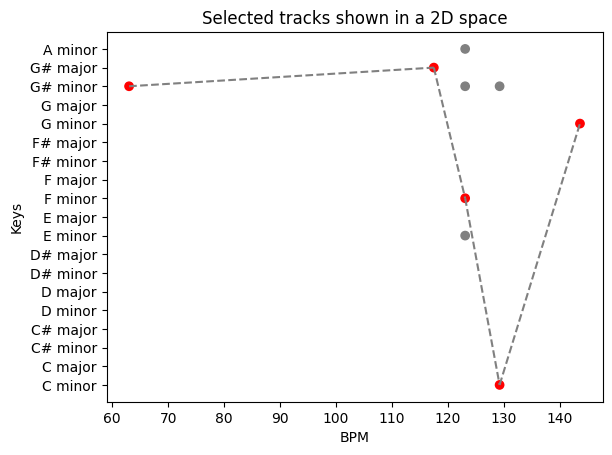

In [9]:
import matplotlib.pyplot as plt
import numpy as np

bpm = []
key = []
selected = []
for track in track_list:
    bpm.append(track.bpm)
    key.append(track.key_idx)
    if track.selected:
        selected.append("red")
    else:
        selected.append("grey")

x = np.array(bpm)
y = np.array(key)
color_array = np.array(selected)

# Create a scatter plot with different colors
plt.scatter(x, y, c=color_array)  # 'bwr' is a colormap (blue-white-red)

# Add labels and a title
plt.xlabel("BPM")
plt.ylabel("Keys")
plt.title("Selected tracks shown in a 2D space")

key_dict = {0: 'C minor', 1: 'C major', 2: 'C# minor', 3: 'C# major', 4: 'D minor', 5: 'D major', 6: 'D# minor', 7: 'D# major', 8: 'E minor', 9: 'E major', 10: 'F minor', 11: 'F major', 12: 'F# minor', 13: 'F# major', 14: 'G minor', 15: 'G major', 16: 'G# minor', 17: 'G# major', 18: 'A minor', 19: 'A major', 20: 'A# minor', 21: 'A# major', 22: 'B minor', 23: 'B major'}

y_values = [i for i in range(24)]
y_labels = [key_dict[value] for value in y_values]

plt.yticks(y_values, y_labels)

# Add lines connecting coordinate pairs
for i in range(len(track_lineup) - 1):
    plt.plot([track_lineup[i].bpm, track_lineup[i+1].bpm], [track_lineup[i].key_idx,track_lineup[i+1].key_idx,],
             color='gray', linestyle='--')

# Display the plot
plt.show()

##### Mix creation

In [5]:
from mixer import Mixer
mixer = Mixer(track_lineup, beat_mode)
mixer.mixPlaylist()

IDX: 0
TRACK: temp_adjusted_track1.wav -> BPM:117.45383522727273 KEY:F# minor
IDX: 1
TRACK: temp_adjusted_track1.wav -> BPM:123.046875 KEY:C minor
IDX: 2
TRACK: temp_adjusted_track1.wav -> BPM:129.19921875 KEY:E major
IDX: 3
TRACK: temp_adjusted_track1.wav -> BPM:143.5546875 KEY:G minor
